# Edafa on ImageNet dataset

This notebook shows an example on how to use Edafa to obtain better results on **classification task**. We use [ImageNet](http://www.image-net.org/) dataset which has **1000 classes**. We use *tensorflow* + *TF-Slim* and pretrained weights of VGG16. At the end we compare results of the same model with and without augmentations. Special thanks to the great [tutorial](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/10/30/image-classification-and-segmentation-using-tensorflow-and-tf-slim/) by Daniil Pakhomov

#### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add our package directory to the path
import sys
sys.path.append('../../')
sys.path.append('../')
sys.path.append('slim')

In [3]:
import tensorflow as tf
from datasets import dataset_utils
from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing
slim = tf.contrib.slim

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Constants

In [4]:
# Filename to use for comparison (4 sample files are given in 'data' folder)
FILE = '001517'

# Input size of the model
IN_SIZE = 224

#### Now download pretrained weights

In [5]:
url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"

# Specify where you want to download the model to
weights_dir = 'weights'

if not tf.gfile.Exists(weights_dir):
    tf.gfile.MakeDirs(weights_dir)
else:
    if not os.path.exists(os.path.join(weights_dir,url.split('/')[-1])):
        dataset_utils.download_and_uncompress_tarball(url, weights_dir)

#### Read and preprocess image

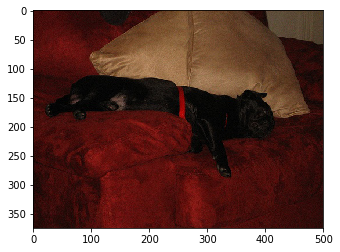

In [6]:
img_path = '../data/images/%s.jpg'%FILE
img = plt.imread(img_path)
plt.imshow(img)

In [7]:
def preprocess(img):
    image = tf.convert_to_tensor(img, dtype=tf.uint8)

    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                         IN_SIZE,
                                                         IN_SIZE,
                                                         is_training=False)

    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    return processed_images

### Exp1: Predict image without augmentation

In [8]:
with tf.Graph().as_default():
    processed_images = preprocess(img)
    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)

    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)

    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(weights_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))

    with tf.Session() as sess:

        # Load weights
        init_fn(sess)

        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        probabilities = sess.run(probabilities)
        probabilities_without = probabilities[0, 0:]

INFO:tensorflow:Restoring parameters from weights/vgg_16.ckpt


### Exp2: Using same model with Edafa

#### step 1: import base class `ClassPredictor`

In [9]:
from edafa import ClassPredictor

#### step 2: inherit `ClassPredictor` and implement the main virtual functions: predict_patches()

In [10]:
class myPredictor(ClassPredictor):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        
    def predict_patches(self,patches):
        with tf.Graph().as_default():
            processed_images = tf.concat([preprocess(img) for img in patches],axis=0)
            # Create the model, use the default arg scope to configure
            # the batch norm parameters. arg_scope is a very conveniet
            # feature of slim library -- you can define default
            # parameters for layers -- like stride, padding etc.
            with slim.arg_scope(vgg.vgg_arg_scope()):
                logits, _ = vgg.vgg_16(processed_images,
                                       num_classes=1000,
                                       is_training=False)

            # In order to get probabilities we apply softmax on the output.
            probabilities = tf.nn.softmax(logits)

            # Create a function that reads the network weights
            # from the checkpoint file that you downloaded.
            # We will run it in session later.
            init_fn = slim.assign_from_checkpoint_fn(
                os.path.join(weights_dir, 'vgg_16.ckpt'),
                slim.get_model_variables('vgg_16'))

            with tf.Session() as sess:

                # Load weights
                init_fn(sess)

                # We want to get predictions, image as numpy matrix
                # and resized and cropped piece that is actually
                # being fed to the network.
                probabilities = sess.run(probabilities)
                return probabilities

#### step 3: make an instance of your class with the correct parameters

In [11]:
p = myPredictor("../../conf/imagenet.json")

#### step 4: call predict_images()

In [12]:
probabilities_with = p.predict_images([img])[0]

INFO:tensorflow:Restoring parameters from weights/vgg_16.ckpt


### Compare results of Exp1 and Exp2

In [13]:
sorted_inds_without = [i[0] for i in sorted(enumerate(-probabilities_without),
                                            key=lambda x:x[1])]
sorted_inds_with = [i[0] for i in sorted(enumerate(-probabilities_with),
                                            key=lambda x:x[1])]

In [14]:
names = imagenet.create_readable_names_for_imagenet_labels()
for i in range(2):
    index = sorted_inds_without[i]
    print('Without Augmentation : %d class => [%s]' % (i+1, names[index+1]))

    index = sorted_inds_with[i]
    print('With Augmentation : %d class => [%s]' % (i+1,names[index+1]))

Without Augmentation : 1 class => [sleeping bag]
With Augmentation : 1 class => [sleeping bag]
Without Augmentation : 2 class => [Doberman, Doberman pinscher]
With Augmentation : 2 class => [schipperke]


both experiments has the same top class. For second-top class, it looks to me more like **schipperke** than **Doberman**!

### Conclusion
Results showed that with the exact same model and by applying Edafa we can obtain better results!